Files already downloaded and verified


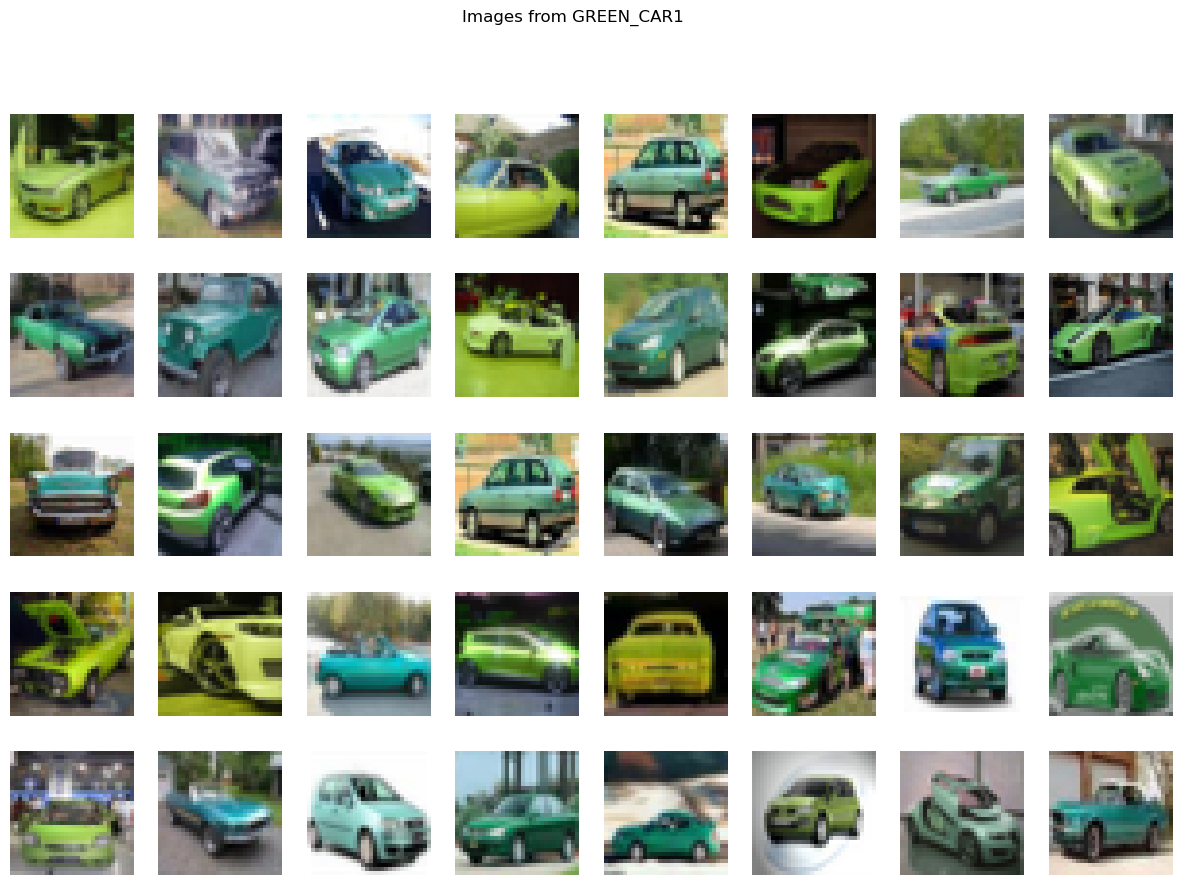

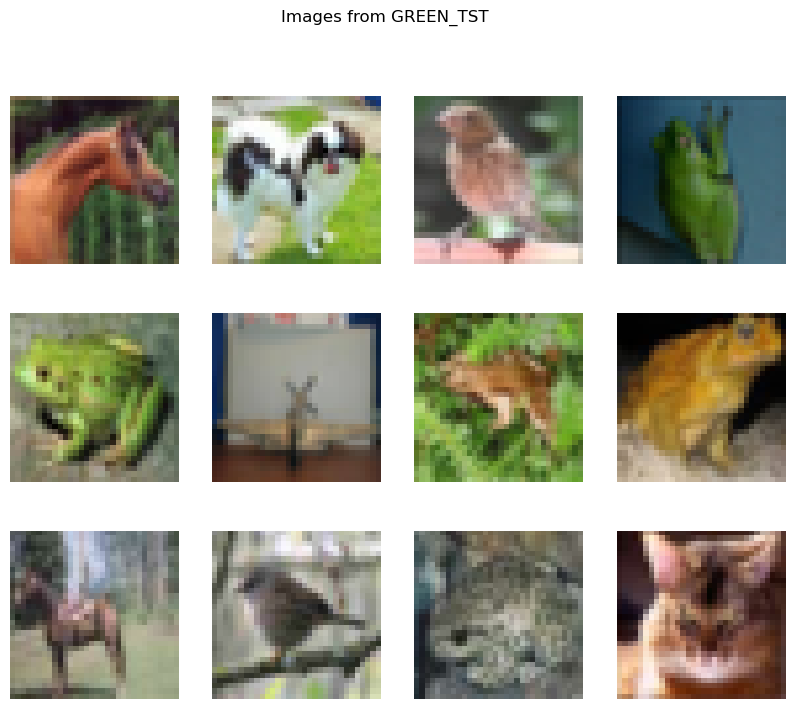

In [1]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# Define the transform to convert the images to tensor and normalize them
transform = transforms.Compose([transforms.ToTensor()])

# Load CIFAR-10 dataset
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Image indices from the GREEN_CAR1 and GREEN_TST lists
GREEN_CAR1 = [389, 1304, 1731, 6673, 13468, 15702, 19165, 19500, 20351, 20764, 21422, 22984, 28027, 29188, 30209, 32941,
              33250, 34145, 34249, 34287, 34385, 35550, 35803, 36005, 37365, 37533, 37920, 38658, 38735, 39824, 39769,
              40138, 41336, 42150, 43235, 47001, 47026, 48003, 48030, 49163]
GREEN_TST = [440, 1061, 1258, 3826, 3942, 3987, 4831, 4875, 5024, 6445, 7133, 9609]

# Display images from GREEN_CAR1
fig, axes = plt.subplots(5, 8, figsize=(15, 10))
fig.suptitle('Images from GREEN_CAR1')

for ax, idx in zip(axes.flatten(), GREEN_CAR1):
    image, label = cifar10[idx]
    ax.imshow(image.permute(1, 2, 0))
    ax.axis('off')

plt.show()

# Display images from GREEN_TST
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
fig.suptitle('Images from GREEN_TST')

for ax, idx in zip(axes.flatten(), GREEN_TST):
    image, label = cifar10[idx]
    ax.imshow(image.permute(1, 2, 0))
    ax.axis('off')

plt.show()


In [2]:
import numpy as np
import torch
import time
from models import CNN, ResNet18
from data_utils import partition_data_iid, partition_data_noniid
from attack_train import test, train_process, attack_process, test_global
from torch.utils.data import DataLoader, Subset
from semantic_attack import load_dataset
import torch.multiprocessing as mp

import torchvision.datasets as datasets


def main():
    # Device configuration
    device = torch.device("cpu")
    device_train = torch.device("cuda" if torch.cuda.is_available() else "mps")
    if torch.cuda.is_available():
        mp.set_start_method('spawn')
    print("Using device:", device)
    torch.set_num_threads(5)
    num_processes = 5
    # Transformations and Dataset Loading

    # train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    # test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    # attack_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    # attack_test_data = torchvision.datasets.MNIST(root='./badtest', train=False, download=True, transform=transform)
    train_data, test_data = load_dataset(False)
    attack_data, attack_test_data = load_dataset(True)
    # 定义 CIFAR 数据集索引
    GREEN_CAR1 = [389, 1304, 1731, 6673, 13468, 15702, 19165, 19500, 20351, 20764, 21422, 22984, 28027, 29188,
                  30209, 32941,
                  33250, 34145, 34249, 34287, 34385, 35550, 35803, 36005, 37365, 37533, 37920, 38658, 38735, 39824,
                  39769,
                  40138, 41336, 42150, 43235, 47001, 47026, 48003, 48030, 49163]
    GREEN_TST = [440, 1061, 1258, 3826, 3942, 3987, 4831, 4875, 5024, 6445, 7133, 9609]

    # 提取指定的图像
    green_car_subset = Subset(train_data, GREEN_CAR1)
    green_car_backdoor_subset = Subset(attack_data, GREEN_CAR1)
    green_car_subset = DataLoader(green_car_subset, batch_size=16, shuffle=False)
    green_car_backdoor_subset = DataLoader(green_car_backdoor_subset, batch_size=16, shuffle=False)
    attack_methods = ["Pixel-backdoors","Semantic-backdoors", "Trojan-backdoors"]

    #Global and Client Model Initialization

    # Parameters for Federated Learning
    C = 1  # Fraction of clients
    B = 50  # Batch size
    E = 3  # Number of local epochs
    l = 0.01  # Learning rate
    ifIID = False  # If IID or non-IID
    num_rounds = 200  # Number of rounds
    for attack_method in attack_methods:
        print("Attack method:", attack_method)

        # Initialize models
        models = [CNN(num_classes=10, device=device).to(device) for _ in range(100)]
        global_model = CNN(num_classes=10, device=device).to(device)
        start = time.time()

        global_model, accuracy,accuracy_green_car, accuracy_green_car_backdoor = FedAvg(num_rounds, C, B, E, l, ifIID, num_processes, device_train, models,
                                                                                          global_model, train_data, test_data, attack_data, attack_test_data, attack_method, green_car_subset, green_car_backdoor_subset)
        np.save(attack_method + 'accuracy', np.array(accuracy))
        np.save(attack_method + 'accuracy_green_car', np.array(accuracy_green_car))
        np.save(attack_method + 'accuracy_green_car_backdoor', np.array(accuracy_green_car_backdoor))
        # Test the global model
        print("Testing the global model")
        test(global_model, DataLoader(test_data, shuffle=True), device_train)
        # Test the badtest model
        print("Testing the badtest model")
        test(global_model, DataLoader(attack_test_data, shuffle=True), device_train)
        torch.save(global_model.state_dict(), f'CNN(single_True_noiid)_global_model_{attack_method}.pth')


# Main Federated Learning Loop
def FedAvg(num_rounds, C, B, E, l, ifIID, num_processes, device_train, models,
                        global_model, train_data, test_data, attack_data, attack_test_data, attack_method, green_car_subset, green_car_backdoor_subset):
    accuracy = []
    accuracy_green_car = []
    accuracy_green_car_backdoor = []
    for round in range(5):
        print(f"Round {round + 1}")
        print("attack_test")
        ac = test(global_model, green_car_backdoor_subset, device_train)
        # Select clients
        backdoor_clients = torch.randperm(len(models))[:int(0.1 * C * len(models))]
        normal_clients = torch.randperm(len(models))[:int(0.9 * C * len(models))]
        normal_clients = torch.tensor(list(normal_clients))
        backdoor_clients = torch.tensor(list(backdoor_clients))
        normal_clients_number = len(normal_clients)
        backdoor_clients_number = len(backdoor_clients)
        total_clients_number = normal_clients_number + backdoor_clients_number
        normal_clients_process = normal_clients_number // num_processes  #number of clients per process
        backdoor_clients_process = backdoor_clients_number // num_processes
        # Prepare data
        if ifIID:
            data = partition_data_iid(train_data, normal_clients_number)
            backdoor_data = partition_data_iid(attack_data, backdoor_clients_number)
        else:
            data = partition_data_noniid(train_data, normal_clients_number, 100)
            backdoor_data = partition_data_noniid(attack_data, backdoor_clients_number, 100)

        # 初始化 weight_accumulator
        weight_accumulator = {name: torch.zeros_like(param) for name, param in global_model.named_parameters()}

        print("Training backdoor clients")
        #Attack
        queue = mp.Queue()
        events = [mp.Event() for _ in range(num_processes)]
        processes = []
        for process_idx in range(num_processes):
            clients_process = backdoor_clients[
                              process_idx * backdoor_clients_process: min((process_idx + 1) * backdoor_clients_process,
                                                                          backdoor_clients_number)]
            p = mp.Process(target=attack_process, args=(
                process_idx * backdoor_clients_process, process_idx, events[process_idx], clients_process, models,
                backdoor_data, ac,B, E,  global_model,
                queue, attack_method, device_train))
            p.start()
            processes.append(p)

        for _ in range(num_processes):
            # 从队列中获取完整的模型对象字典
            trained_models = queue.get()
            # 替换本地模型
            for client, model in trained_models.items():
                for name, param in model.named_parameters():
                    # if helper.params.get('tied', False) and name == 'decoder.weight' or '__' in name:
                    #     continue
                    weight_accumulator[name] += (param.data - global_model.state_dict()[name]) / total_clients_number
        for event in events:
            event.set()

        # del trained_models
        for p in processes:
            # print("p", p.name)
            p.join(timeout=10)

        # for client_model in normal_clients:
        #     for (name, param), (_, global_param) in zip(models[client_model].named_parameters(),
        #                                                 global_model.named_parameters()):
        #         global_param.data += param.data / total_clients_number
        #
        # for client_model in backdoor_clients:
        #     for (name, param), (_, global_param) in zip(models[client_model].named_parameters(),
        #                                                 global_model.named_parameters()):
        #         global_param.data += param.data / total_clients_number

        del trained_models
        print("Training normal clients")
        processes = []
        queue = (mp.Queue())
        events = [mp.Event() for _ in range(num_processes)]

        for process_idx in range(num_processes):
            clients_process = normal_clients[
                              process_idx * normal_clients_process: min((process_idx + 1) * normal_clients_process,
                                                                        normal_clients_number)]
            p = mp.Process(target=train_process, args=(
                process_idx * normal_clients_process, process_idx, events[process_idx], clients_process, models, data,
                B, E, l, global_model,
                queue, device_train))
            p.start()
            processes.append(p)
        model1 = None
        for _ in range(num_processes):
            # 从队列中获取完整的模型对象字典
            trained_models = queue.get()
            # 替换本地模型
            for client, model in trained_models.items():
                model1 = model
                # for name, param in model.named_parameters():
                #     if 'fc' in name:
                #         print(f"Parameter name: {name}")
                #         print(param.data)  # 打印参数的具体值
                #         print("------")
                for name, param in model.named_parameters():
                    # if helper.params.get('tied', False) and name == 'decoder.weight' or '__' in name:
                    #     continue
                    weight_accumulator[name] += (param.data - global_model.state_dict()[name]) / total_clients_number

        del trained_models

        for event in events:
            event.set()
        # print("Processes finished")
        for p in processes:
            p.join(timeout=10)
            # if p.is_alive():
            #     print(f"Thread {p.name} did not finish in time")
            # else:
            #     print(f"Thread {p.name} finished in time")
        global_model = model1
        # 使用 weight_accumulator 更新 global_model
        for name, param in global_model.named_parameters():
            if name in weight_accumulator:
                param.data += weight_accumulator[name]

        print("Test the global model")
        accuracy.append(test(global_model, DataLoader(test_data, shuffle=True), device_train))

        print("Testing green car")
        accuracy_green_car.append(test(global_model, green_car_subset, device_train))
        print("Testing green car backdoor")
        accuracy_green_car_backdoor.append(test(global_model, green_car_backdoor_subset, device_train))



    for round in range(5,num_rounds):
        print(f"Round {round + 1}")

        # Select clients
        backdoor_clients = torch.randperm(len(models))[:int(0 * C * len(models))]
        normal_clients = torch.randperm(len(models))[:int(1 * C * len(models))]
        normal_clients = torch.tensor(list(normal_clients))
        backdoor_clients = torch.tensor(list(backdoor_clients))
        normal_clients_number = len(normal_clients)
        backdoor_clients_number = len(backdoor_clients)
        total_clients_number = normal_clients_number + backdoor_clients_number
        normal_clients_process = normal_clients_number // num_processes  # number of clients per process
        backdoor_clients_process = backdoor_clients_number // num_processes
        # Prepare data
        if ifIID:
            data = partition_data_iid(train_data, normal_clients_number)
            backdoor_data = partition_data_iid(attack_data, backdoor_clients_number)
        else:
            data = partition_data_noniid(train_data, normal_clients_number, 100)
            backdoor_data = partition_data_noniid(attack_data, backdoor_clients_number, 100)

        # 初始化 weight_accumulator
        weight_accumulator = {name: torch.zeros_like(param) for name, param in global_model.named_parameters()}

        # # Attack
        # queue = mp.Queue()
        # events = [mp.Event() for _ in range(num_processes)]
        # processes = []
        # for process_idx in range(num_processes):
        #     clients_process = backdoor_clients[
        #                       process_idx * backdoor_clients_process: min((process_idx + 1) * backdoor_clients_process,
        #                                                                   backdoor_clients_number)]
        #     p = mp.Process(target=attack_process, args=(
        #         process_idx * backdoor_clients_process, process_idx, events[process_idx], clients_process, models,
        #         backdoor_data, green_car_backdoor_subset, B, E, global_model,
        #         queue, attack_method, device_train))
        #     p.start()
        #     processes.append(p)
        #
        # for _ in range(num_processes):
        #     # 从队列中获取完整的模型对象字典
        #     trained_models = queue.get()
        #     # 替换本地模型
        #     for client, model in trained_models.items():
        #         for name, param in model.named_parameters():
        #             # if helper.params.get('tied', False) and name == 'decoder.weight' or '__' in name:
        #             #     continue
        #             weight_accumulator[name] += (param.data - global_model.state_dict()[name]) / total_clients_number
        # for event in events:
        #     event.set()
        #
        # # del trained_models
        # for p in processes:
        #     # print("p", p.name)
        #     p.join(timeout=10)
        #
        #
        # del trained_models
        print("Training normal clients")
        processes = []
        queue = (mp.Queue())
        events = [mp.Event() for _ in range(num_processes)]

        for process_idx in range(num_processes):
            clients_process = normal_clients[
                              process_idx * normal_clients_process: min((process_idx + 1) * normal_clients_process,
                                                                        normal_clients_number)]
            p = mp.Process(target=train_process, args=(
                process_idx * normal_clients_process, process_idx, events[process_idx], clients_process, models, data,
                B, E, l, global_model,
                queue, device_train))
            p.start()
            processes.append(p)
        model1 = None
        for _ in range(num_processes):
            # 从队列中获取完整的模型对象字典
            trained_models = queue.get()
            # 替换本地模型
            for client, model in trained_models.items():
                model1 = model
                # for name, param in model.named_parameters():
                #     if 'fc' in name:
                #         print(f"Parameter name: {name}")
                #         print(param.data)  # 打印参数的具体值
                #         print("------")
                for name, param in model.named_parameters():
                    # if helper.params.get('tied', False) and name == 'decoder.weight' or '__' in name:
                    #     continue
                    weight_accumulator[name] += (param.data - global_model.state_dict()[name]) / total_clients_number

        del trained_models

        for event in events:
            event.set()
        # print("Processes finished")
        for p in processes:
            p.join(timeout=10)
            # if p.is_alive():
            #     print(f"Thread {p.name} did not finish in time")
            # else:
            #     print(f"Thread {p.name} finished in time")
        global_model = model1
        # 使用 weight_accumulator 更新 global_model
        for name, param in global_model.named_parameters():
            if name in weight_accumulator:
                param.data += weight_accumulator[name]

        print("Test the global model")
        accuracy.append(test(global_model, DataLoader(test_data, shuffle=True), device_train))

        print("Testing green car")
        accuracy_green_car.append(test(global_model, green_car_subset, device_train))
        print("Testing green car backdoor")
        accuracy_green_car_backdoor.append(test(global_model, green_car_backdoor_subset, device_train))

    return global_model, accuracy, accuracy_green_car, accuracy_green_car_backdoor


if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Unhandled exception: {e}")


Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
number 1
Attack method: Pixel-backdoors
Round 1
attack_test
: 10.0%
Unhandled exception: need at least one array to concatenate
